In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.DataFrame()
df['feature1'] = [9,9,7,6,6,5,4,3,2,1]
df['feature2'] = [2,9,8,5,9,1,8,6,3,5]
df['target'] =[-1,-1,1,-1,1,-1,1,-1,1,1]
df['w'] = 1/df.shape[0]
df

,feature1,feature2,target,w
0,9,2,-1,0.1
1,9,9,-1,0.1
2,7,8,1,0.1
3,6,5,-1,0.1
4,6,9,1,0.1
5,5,1,-1,0.1
6,4,8,1,0.1
7,3,6,-1,0.1
8,2,3,1,0.1
9,1,5,1,0.1


In [6]:
X = df.iloc[:,0:2].values
y = df.iloc[:,2].values

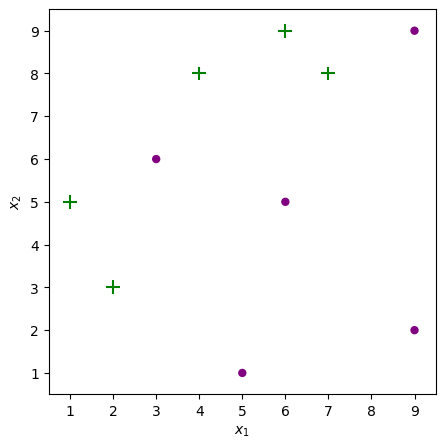

In [7]:
from typing import Optional
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#visualizing our datapoints
def plot_adaboost(X: np.ndarray,
                  y: np.ndarray,
                  clf=None,
                  sample_weights: Optional[np.ndarray] = None,
                  annotate: bool = False,
                  ax: Optional[mpl.axes.Axes] = None) -> None:
    assert set(y) == {-1, 1}, 'Expecting response labels to be ±1'
    if not ax:
        fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
        fig.set_facecolor('white')
    pad = 1
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad
    if sample_weights is not None:
        sizes = np.array(sample_weights) * X.shape[0] * 100
    else:
        sizes = np.ones(shape=X.shape[0]) * 100
    X_pos = X[y == 1]
    sizes_pos = sizes[y == 1]
    ax.scatter(*X_pos.T, s=sizes_pos, marker='+', color='green')
    X_neg = X[y == -1]
    sizes_neg = sizes[y == -1]
    ax.scatter(*X_neg.T, s=sizes_neg, marker='.', c='purple')
    if clf:
        plot_step = 0.01
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        if list(np.unique(Z)) == [1]:
            fill_colors = ['g']
        else:
            fill_colors = ['purple', 'g']
        ax.contourf(xx, yy, Z, colors=fill_colors, alpha=0.2)
    if annotate:
        for i, (x, y) in enumerate(X):
            offset = 0.05
            ax.annotate(f'$x_{i + 1}$', (x + offset, y - offset))
    ax.set_xlim(x_min+0.5, x_max-0.5)
    ax.set_ylim(y_min+0.5, y_max-0.5)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
plot_adaboost(X, y)

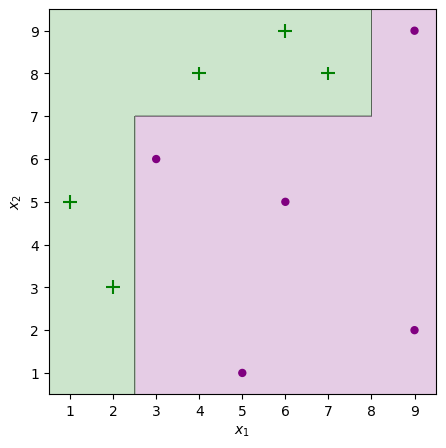

In [9]:
class AdaBoost:
    def __init__(self):
        self.stumps = None
        self.stump_weights = None
        self.errors = None
        self.sample_weights = None

    def _check_X_y(self, X, y):
        assert set(y) == {-1, 1}, 'Response variable must be ±1'
        return X, y

from sklearn.tree import DecisionTreeClassifier
def fit(self, X: np.ndarray, y: np.ndarray, iters: int):
    X, y = self._check_X_y(X, y)
    n = X.shape[0]
    self.sample_weights = np.zeros(shape=(iters, n))
    self.stumps = np.zeros(shape=iters, dtype=object)
    self.stump_weights = np.zeros(shape=iters)
    self.errors = np.zeros(shape=iters)
    self.sample_weights[0] = np.ones(shape=n) / n
    for t in range(iters):
        curr_sample_weights = self.sample_weights[t]
        stump = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)
        stump = stump.fit(X, y, sample_weight=curr_sample_weights)
        stump_pred = stump.predict(X)
        err = curr_sample_weights[(stump_pred != y)].sum()# / n
        stump_weight = np.log((1 - err) / err) / 2
        new_sample_weights = (curr_sample_weights * np.exp(-stump_weight * y * stump_pred))
        new_sample_weights /= new_sample_weights.sum()
        if t+1 < iters:
            self.sample_weights[t+1] = new_sample_weights
        self.stumps[t] = stump
        self.stump_weights[t] = stump_weight
        self.errors[t] = err
    return self
def predict(self, X):
    stump_preds = np.array([stump.predict(X) for stump in self.stumps])
    return np.sign(np.dot(self.stump_weights, stump_preds))
AdaBoost.fit = fit
AdaBoost.predict = predict
clf = AdaBoost().fit(X, y, iters=10)
plot_adaboost(X, y, clf)

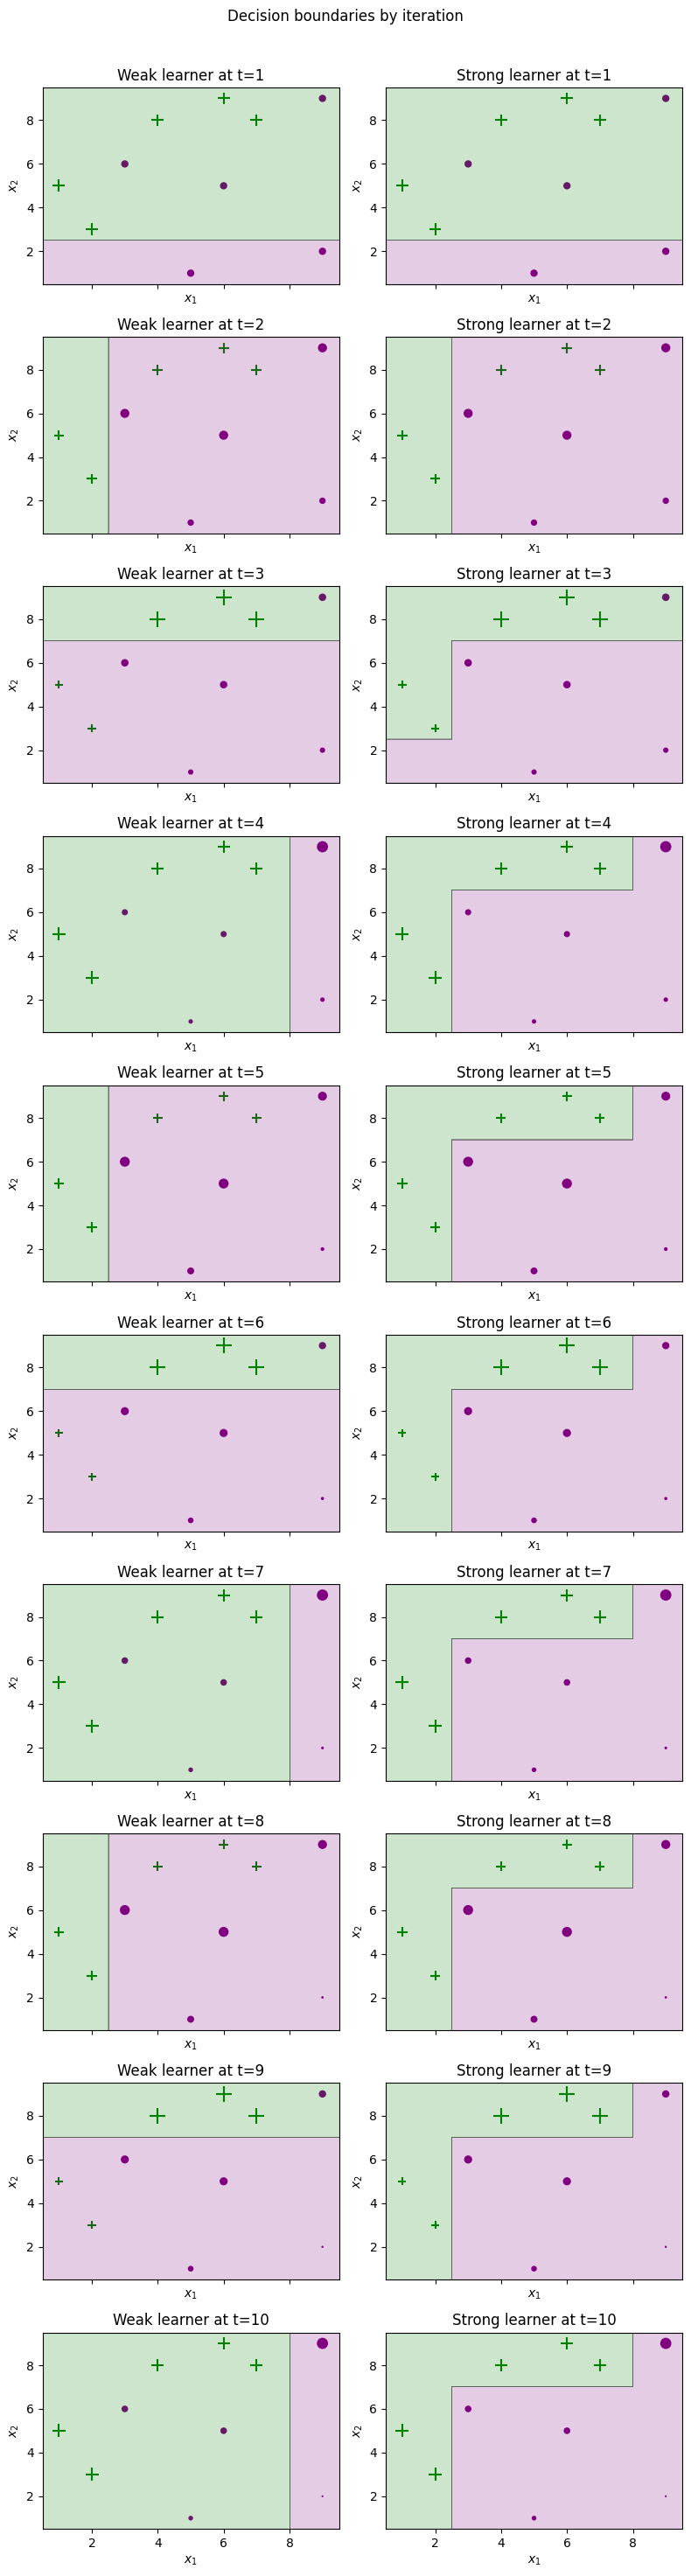

In [10]:
def truncate_adaboost(clf, t: int):
    assert t > 0, 't must be a positive integer'
    from copy import deepcopy
    new_clf = deepcopy(clf)
    new_clf.stumps = clf.stumps[:t]
    new_clf.stump_weights = clf.stump_weights[:t]
    return new_clf

def plot_staged_adaboost(X, y, clf, iters=10):
    fig, axes = plt.subplots(figsize=(8, iters*3),
                             nrows=iters,
                             ncols=2,
                             sharex=True,
                             dpi=100)
    fig.set_facecolor('white')
    _ = fig.suptitle('Decision boundaries by iteration')
    for i in range(iters):
        ax1, ax2 = axes[i]
        _ = ax1.set_title(f'Weak learner at t={i + 1}')
        plot_adaboost(X, y, clf.stumps[i],
                      sample_weights=clf.sample_weights[i],
                      annotate=False, ax=ax1)
        trunc_clf = truncate_adaboost(clf, t=i + 1)
        _ = ax2.set_title(f'Strong learner at t={i + 1}')
        plot_adaboost(X, y, trunc_clf,
                      sample_weights=clf.sample_weights[i],
                      annotate=False, ax=ax2)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()
clf = AdaBoost().fit(X, y, iters=10)
plot_staged_adaboost(X, y, clf)

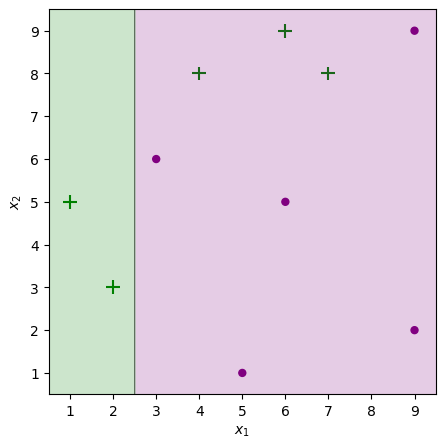

In [12]:
# Adaboost classifier with n_estimators=1
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
abc = AdaBoostClassifier(n_estimators=1,learning_rate=1)
model = abc.fit(X_train, y_train)
y_pred = model.predict(X_test)
plot_adaboost(X, y, model)

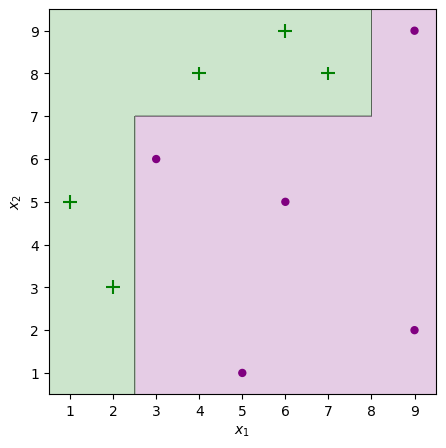

In [13]:
abc = AdaBoostClassifier(n_estimators=5,learning_rate=1)
model = abc.fit(X_train, y_train)
y_pred = model.predict(X_test)
plot_adaboost(X, y, model)

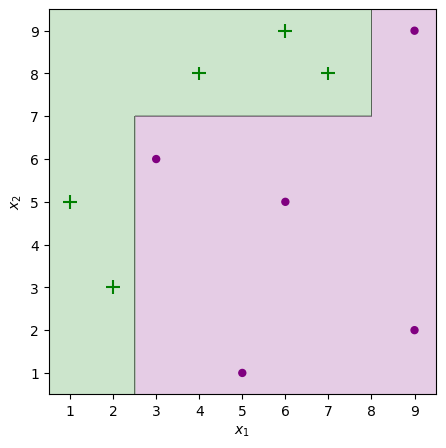

In [14]:
abc = AdaBoostClassifier(n_estimators=10,learning_rate=1)
model = abc.fit(X_train, y_train)
y_pred = model.predict(X_test)
plot_adaboost(X, y, model)